In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tqdm

In [2]:
import torch

import plotly.graph_objects as go

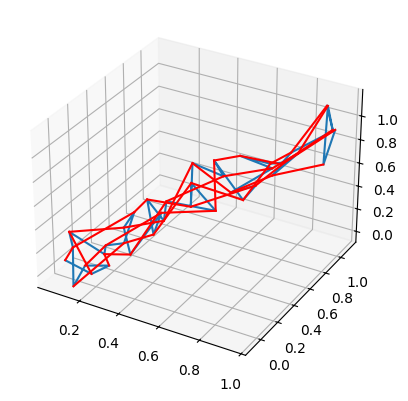

In [251]:
# a simple fdg example with pytorch 

# generate test data
num_points = 40
# initialize points as a line 
points = np.zeros((num_points, 3))
points[:, 0] = np.linspace(0, 1, num_points)
points[:, 1] = np.linspace(0, 1, num_points)
points[:, 2] = np.linspace(0, 1, num_points)
# add noise
np.random.seed(42)
points += np.random.normal(0, 0.1, points.shape)

# contacts_constrain, randomly select 5 pairs of points to be in contact
contacts = []
for i in range(0, num_points-5):
    contacts.append([i,i+5])

# plot the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# line plot
#ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.plot(points[:, 0], points[:, 1], points[:, 2])
for c in contacts:
    ax.plot([points[c[0], 0], points[c[1], 0]], [points[c[0], 1], points[c[1], 1]], [points[c[0], 2], points[c[1], 2]], 'r')
plt.show()

In [282]:

def calc_forces(points, contacts, k_backbone=1, k_repulsion=1, k_contact=1, k_nearest=5):
    num_points = points.shape[0]
    forces = np.zeros((num_points, 3))
    
    # calculate backbone forces based on distance, larger distance induces stronger attractive force
    for i in range(num_points - 1):
        diff = points[i + 1] - points[i]
        dist = np.linalg.norm(diff)
        if dist > 0:  # Avoid division by zero
            forces[i] += k_backbone * diff / dist
            forces[i + 1] += k_backbone * -diff / dist
    
    # calculate repulsion forces, use kd-tree to find top k nearest points and calculate repulsion forces
    tree = cKDTree(points)
    for i in range(num_points):
        _, idx = tree.query(points[i], k=min(k_nearest, num_points))
        for j in idx:
            if i != j:
                diff = points[i] - points[j]
                dist = np.linalg.norm(diff)
                if dist > 0:  # Avoid division by zero
                    forces[i] += k_repulsion * diff / dist
    
    # calculate contact forces
    for c in contacts:
        diff0 = points[c[1]] - points[c[0]]
        dist0 = np.linalg.norm(diff0)
        if dist0 > 0:  # Avoid division by zero
            forces[c[0]] += k_contact * diff0 / dist0
            forces[c[1]] += k_contact * -diff0 / dist0
    
    return forces

In [309]:
np.mean(forces**2)

4.866677985760856

In [310]:
def fdg(points, contacts, k_backbone=1, k_repulsion=1, k_contact=1, k_nearest=5,num_iter=100, lr=0.01):
    points = points.copy()
    num_points = points.shape[0]
    for i in tqdm.tqdm(range(num_iter)):
        forces = calc_forces(points, contacts, k_backbone, k_repulsion, k_contact, k_nearest)
        points += lr * forces
        # print RMS force
        if i % 200 == 0:
            print(np.sqrt(np.mean(forces**2)))
    return points

In [316]:
# randomly initialize points
points = np.random.rand(num_points, 3)

fdg_points = fdg(points, contacts, k_backbone=1, k_repulsion=1, k_contact=1, k_nearest=5, num_iter=1000, lr=0.05)

  3%|▎         | 30/1000 [00:00<00:06, 149.62it/s]

1.5686124555112237


 22%|██▏       | 221/1000 [00:01<00:04, 173.24it/s]

0.7232569921855994


 42%|████▏     | 424/1000 [00:02<00:03, 187.63it/s]

0.6875023084836409


 63%|██████▎   | 630/1000 [00:03<00:01, 223.85it/s]

0.7737909486758121


 84%|████████▍ | 839/1000 [00:04<00:00, 226.26it/s]

0.7504906488204149


100%|██████████| 1000/1000 [00:05<00:00, 198.43it/s]


Text(0.5, 1.0, 'FDG points')

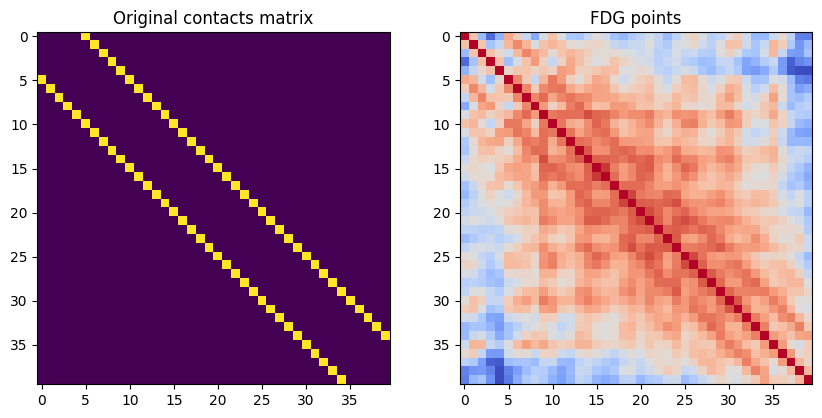

In [317]:
# contacts matrix, distance matrix of fdg_points, side by side
from scipy.spatial.distance import pdist, squareform

contacts_matrix= np.zeros((num_points, num_points))
for c in contacts:
    contacts_matrix[c[0], c[1]] = 1
    contacts_matrix[c[1], c[0]] = 1

dist_fdg = squareform(pdist(fdg_points))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(contacts_matrix)
ax[0].set_title('Original contacts matrix')
ax[1].imshow(dist_fdg,cmap="coolwarm_r")
ax[1].set_title('FDG points')

In [318]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=fdg_points[:,0], y=fdg_points[:,1], z=fdg_points[:,2], mode='markers', marker=dict(size=10, color=[i for i in range(fdg_points.shape[0])], colorscale='Reds', opacity=1)))
fig.add_trace(go.Scatter3d(x=fdg_points[:,0], y=fdg_points[:,1], z=fdg_points[:,2], mode='lines', line=dict(color='blue', width=5)))


fig.update_layout(width=800, height=800)